## Imports

In [1]:
import os
from bioio import BioImage
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from tnia.deconvolution.richardson_lucy import  richardson_lucy_cp
from tnia.deconvolution.gaussian_psf import gaussian_2d

## Define paths

Define path where tg images are, path where current images interest are and image_name....

This block can be tweaked for different scenarios.

In [2]:
tg_image_path = r'D:\images\tnia-python-images\tg\2024_10_22_ts_decon'
tg_image_path = r'/home/bnorthan/images/tnia-python-images/tg/'
image_path = r'_small_data_/[AS-00304]/1x1_FOVs/'
image_name = r'Slide 1 - A02 - ROI 01_1x1_FOVs - DAPI.tif'

image_path = r'_small_data_/[AS-00304]/roi_8bit/'
image_name = r'C2C12_A02-DAPI.tif'
image_name = r'C2C12_A02-FITC.tif'

full_name = os.path.join(tg_image_path, image_path, image_name)
#image_path = r'_small_data_\[AS-00344]\3x3_FOVs'
#image_name = r'Slide 1 - Region 001 - ROI 02 - DAPI.tif'


## Open image 

... get image data as numpy array and inspect meta data

In [3]:
try:
    bioimg = BioImage(full_name)

    img = np.squeeze(bioimg.data)

    print(img.shape)
    print(bioimg.dims.order)

    print(bioimg.physical_pixel_sizes.X)
    print(bioimg.physical_pixel_sizes.Y)
    print(bioimg.physical_pixel_sizes.Z)
except:
    img = imread(full_name)

    print(img.shape)

    print('no bioimg')

(33830, 34684)
no bioimg


## Take a look at the data

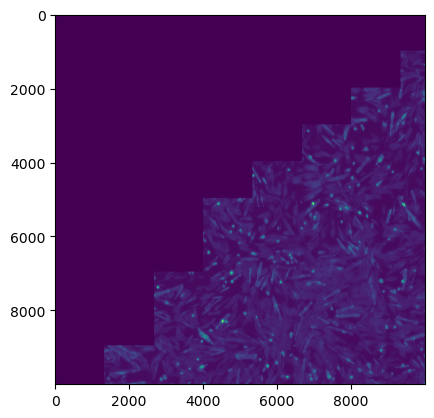

In [4]:
img = img[:10000, :10000]

plt.imshow(np.squeeze(img))

In [5]:
sigma = 1
psf = gaussian_2d(129,sigma)

## Create a mask of saturated pixels

Create a mask which is 1 if the pixel is valid, but 0 if not valid (in this case saturated)

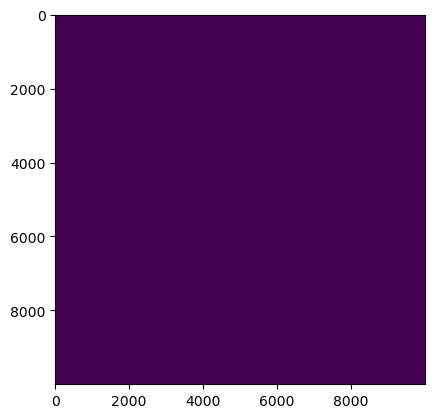

In [6]:
mask  = np.ones_like(img)
dtype = img.dtype

if dtype == np.uint8:
    mask[img==255] = 0


plt.imshow(mask)

In [8]:
from skimage.morphology import binary_dilation
import importlib
import tnia.deconvolution.richardson_lucy_dask_cp

# Reload the module
importlib.reload(tnia.deconvolution.richardson_lucy_dask_cp)

decons = []
names = []
sigmas = [1,2]
num_iterations = 200

for sigma in sigmas:
    psf = gaussian_2d(33,sigma)
    decon_cp=tnia.deconvolution.richardson_lucy_dask_cp.richardson_lucy_dask_cp(img,psf,num_iterations,debug=True)
    decons.append(decon_cp)
    names.append(f'sigma={sigma}_iter={num_iterations}')
    #decon_cp_saturation_masked = richardson_lucy_cp(img,psf,num_iterations,mask=mask)
    #decons.append(decon_cp_saturation_masked)
    #names.append(f'sigma={sigma}_iter={num_iterations}_masked')

richardson_lucy_dask_cp

image size (10000, 10000)
psf size (33, 33)
gpu mem is  1.28582763671875
rl mem is  7.115614946000278
chunk factor is  4.0
chunk size is (2500.0, 2500.0)
start dask task
check dimensions
image dimension is 0
start dask task
check dimensions
image dimension is 0
start dask task
check dimensions

start rlnc
gpu num is 0
block id is (0, 0)
block info is {0: {'shape': (10060, 10060), 'num-chunks': (4, 4), 'array-location': [(0, 2510), (0, 2510)], 'chunk-location': (0, 0)}, None: {'shape': (10060, 10060), 'num-chunks': (4, 4), 'array-location': [(0, 2510), (0, 2510)], 'chunk-location': (0, 0), 'chunk-shape': (2510, 2510), 'dtype': <class 'numpy.float32'>}}
using flat sheet

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
putting gpu num back 0
start dask task
check dimensions

start rlnc
gpu num is 0
block id is (1, 1)
block info is {0: {'shape': (10060, 10060), 'num-chunks': (4, 4), 'array-location': [(2510, 5030), (2510, 5030)], 'chunk-locati

In [119]:
from skimage.io import imsave

out_path = os.path.join(tg_image_path, image_path, 'deconvolutions')

if not os.path.exists(out_path):
    os.makedirs(out_path)

for decon, name in zip(decons, names):
    imsave(os.path.join(out_path, f'{image_name}_{name}.tif'), decon)

In [9]:
import napari

viewer = napari.Viewer()
viewer.add_image(img, name='original')
for decon, name in zip(decons, names):
    viewer.add_image(decon, name=name)
